Point Target Detection for Video
Processing video file: Downloads/test video.mp4
Video properties: 720x720, 25 FPS, 281 frames


C:\Users\Vaibhav\AppData\Local\Temp\ipykernel_6672\2081959641.py:87: RuntimeWarning: overflow encountered in scalar subtract
  r = (s0 - s1) / (s1 - s2 + 1e-6)


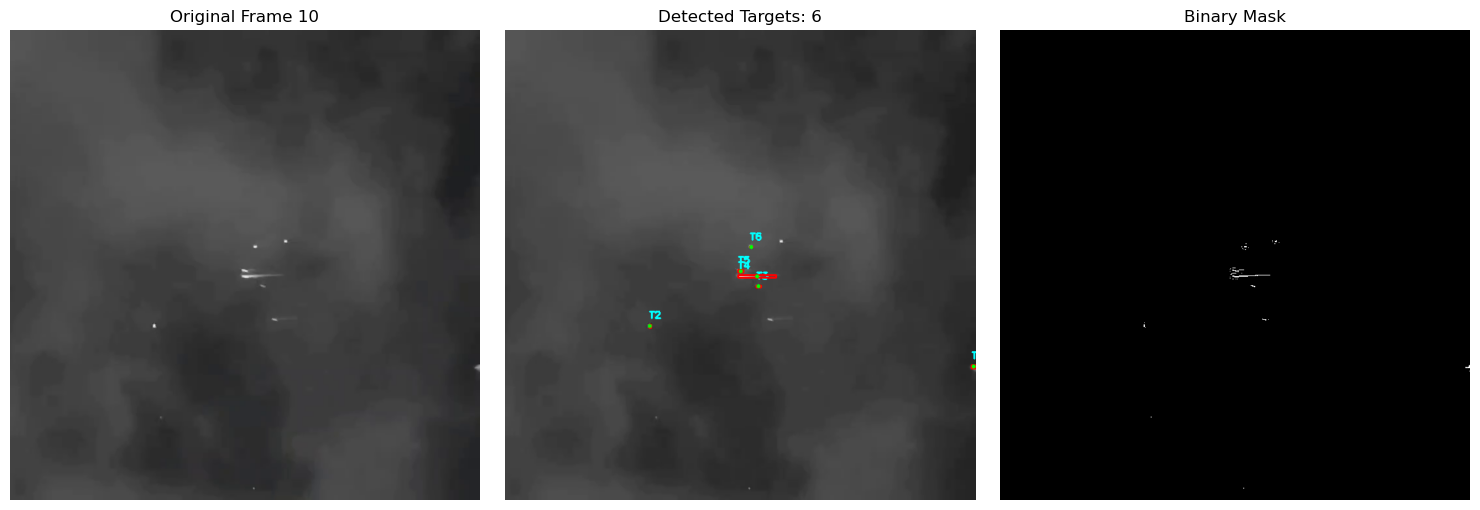

Frame 10: 6 targets at [(716, 515), (221, 453), (387, 392), (385, 377), (360, 369), (376, 332)]


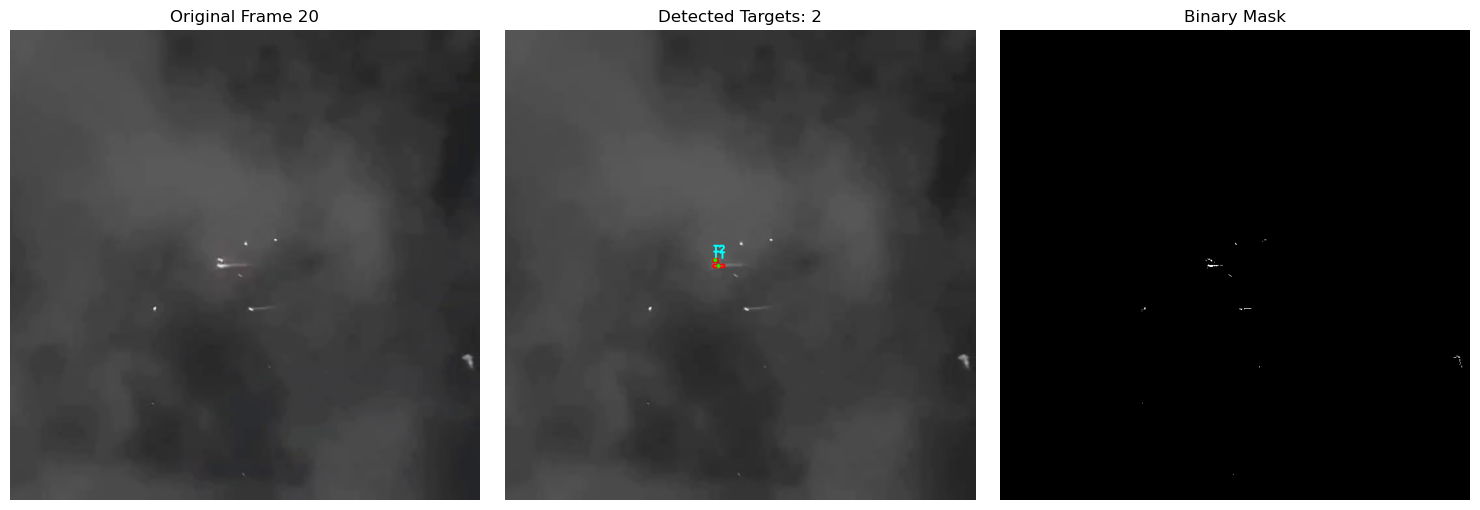

Frame 20: 2 targets at [(326, 361), (321, 352)]
Processed frame 30/281 - Targets detected: 8


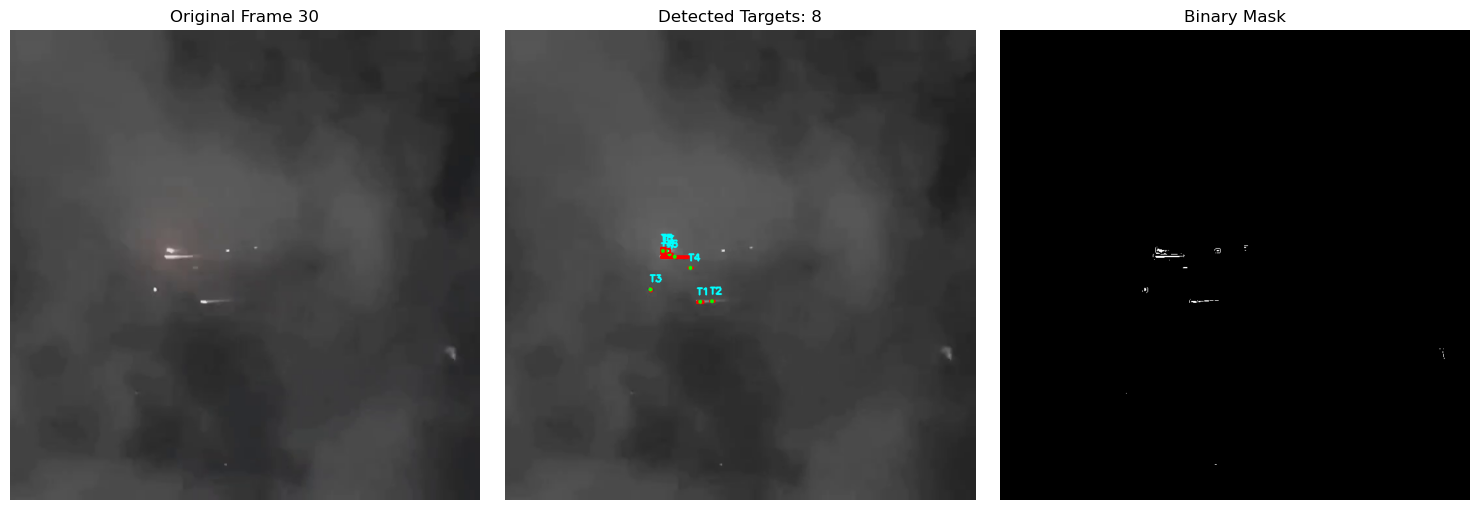

Frame 30: 8 targets at [(298, 416), (316, 415), (222, 397), (283, 364), (259, 347), (251, 343), (246, 338), (241, 338)]


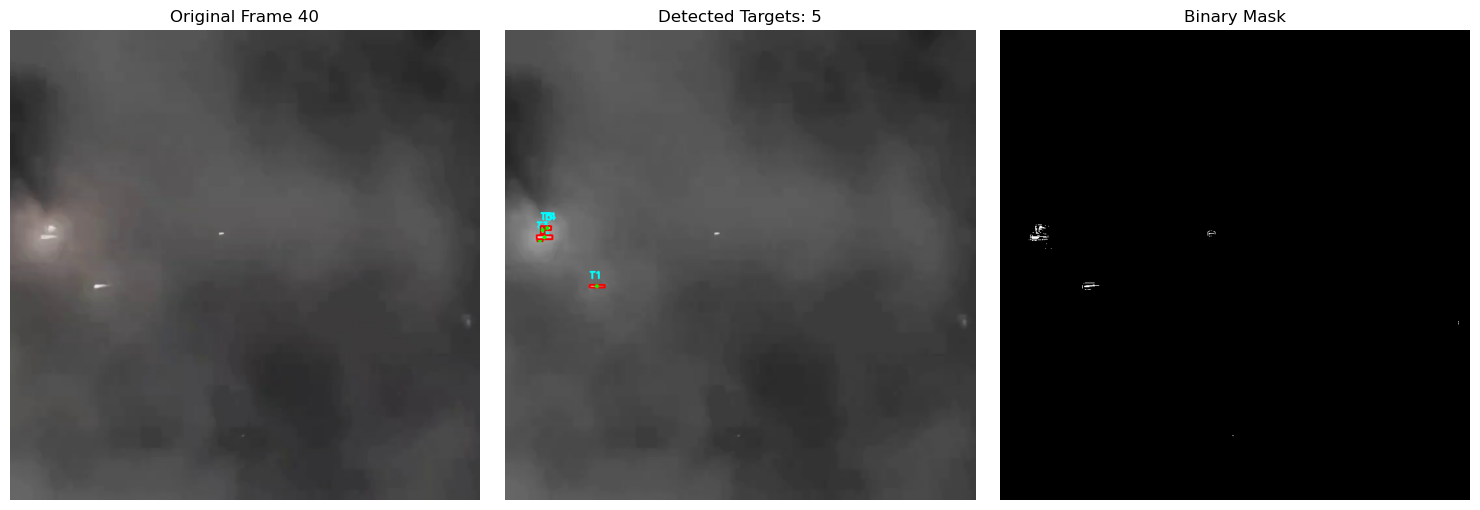

Frame 40: 5 targets at [(140, 392), (53, 322), (60, 317), (64, 303), (57, 306)]


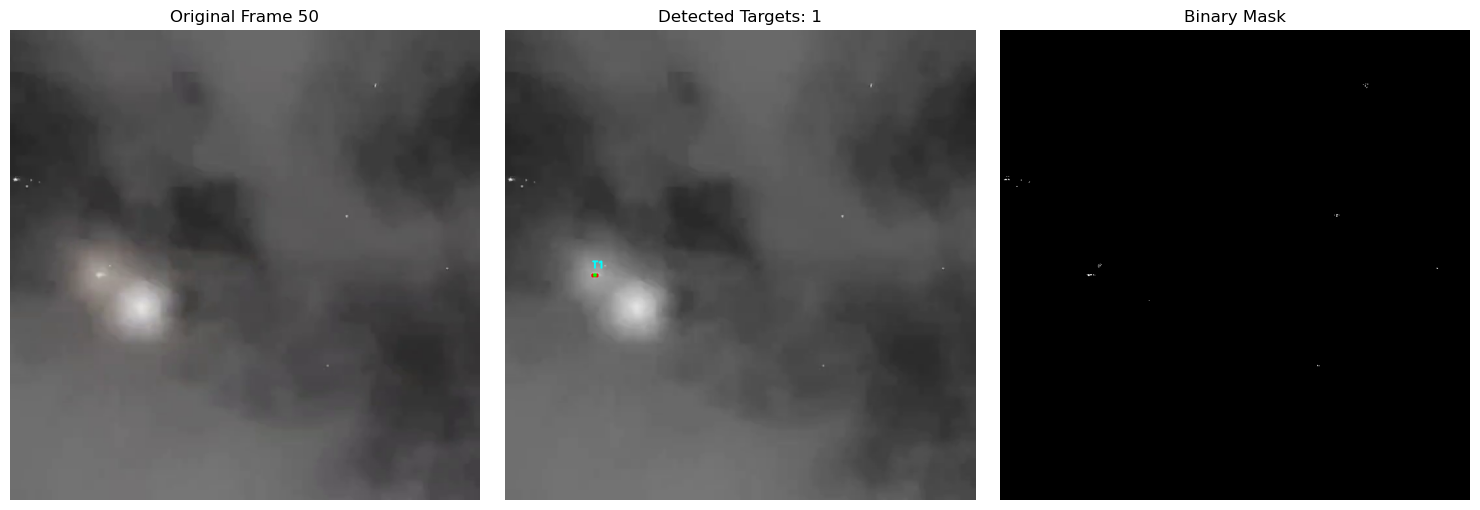

Frame 50: 1 targets at [(137, 375)]
Processed frame 60/281 - Targets detected: 1


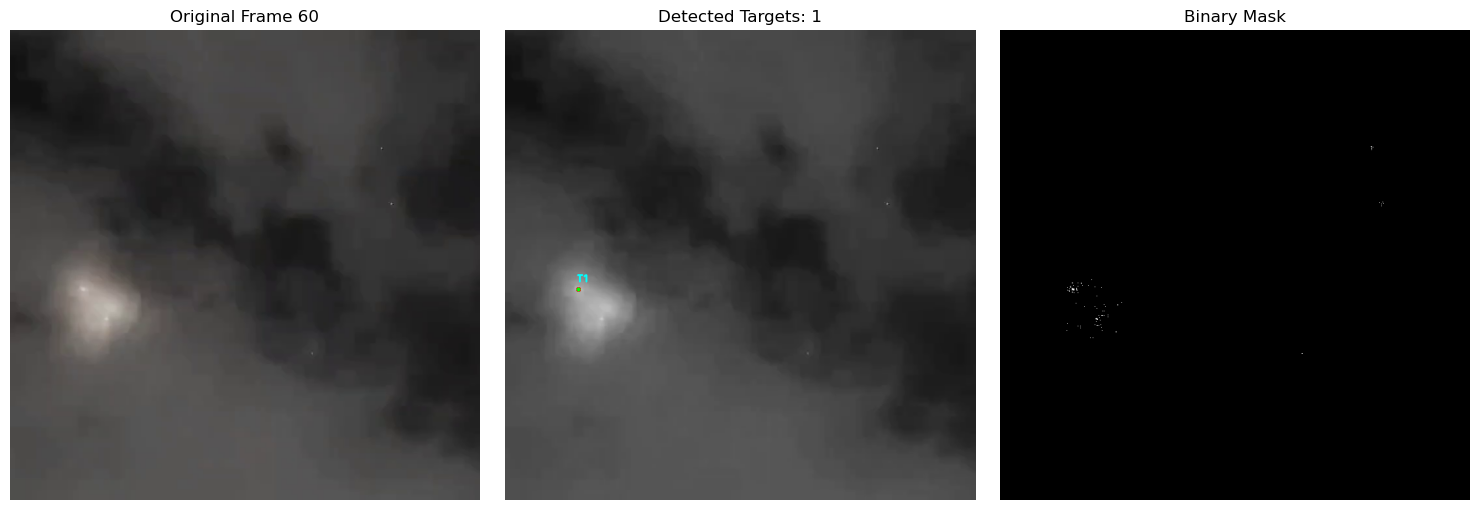

Frame 60: 1 targets at [(112, 397)]


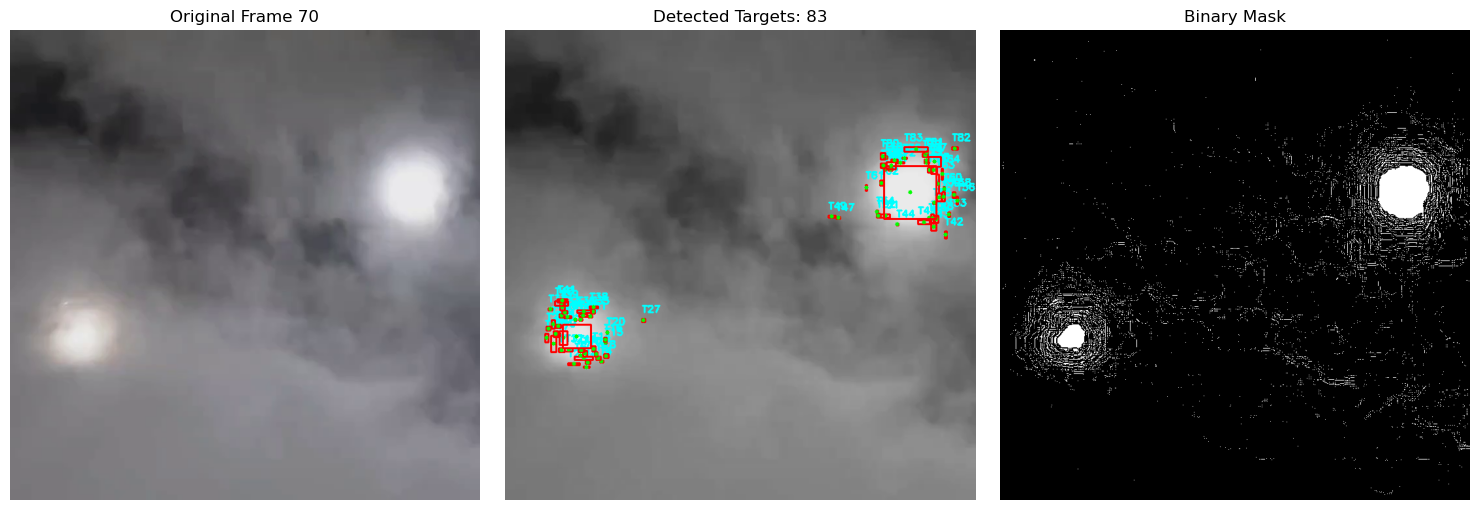

Frame 70: 83 targets at [(124, 516), (105, 511), (126, 509), (147, 507), (142, 502), (120, 502), (115, 498), (154, 499), (139, 496), (122, 495), (116, 490), (97, 489), (86, 490), (135, 488), (153, 478), (153, 474), (74, 480), (63, 471), (82, 466), (156, 463), (89, 471), (77, 465), (66, 457), (109, 469), (81, 453), (73, 450), (211, 444), (115, 443), (107, 443), (95, 439), (130, 438), (119, 437), (86, 437), (91, 432), (134, 431), (120, 431), (69, 427), (135, 424), (87, 424), (86, 418), (87, 414), (673, 313), (655, 301), (599, 297), (640, 294), (648, 287), (509, 287), (659, 289), (499, 285), (653, 288), (581, 284), (570, 284), (678, 282), (568, 278), (656, 264), (691, 261), (663, 256), (686, 252), (670, 255), (671, 243), (552, 241), (575, 234), (661, 235), (668, 220), (649, 214), (589, 213), (580, 213), (655, 214), (619, 248), (578, 207), (644, 203), (604, 203), (590, 207), (644, 199), (595, 199), (610, 196), (656, 201), (581, 195), (642, 191), (577, 193), (644, 187), (687, 181), (628, 18

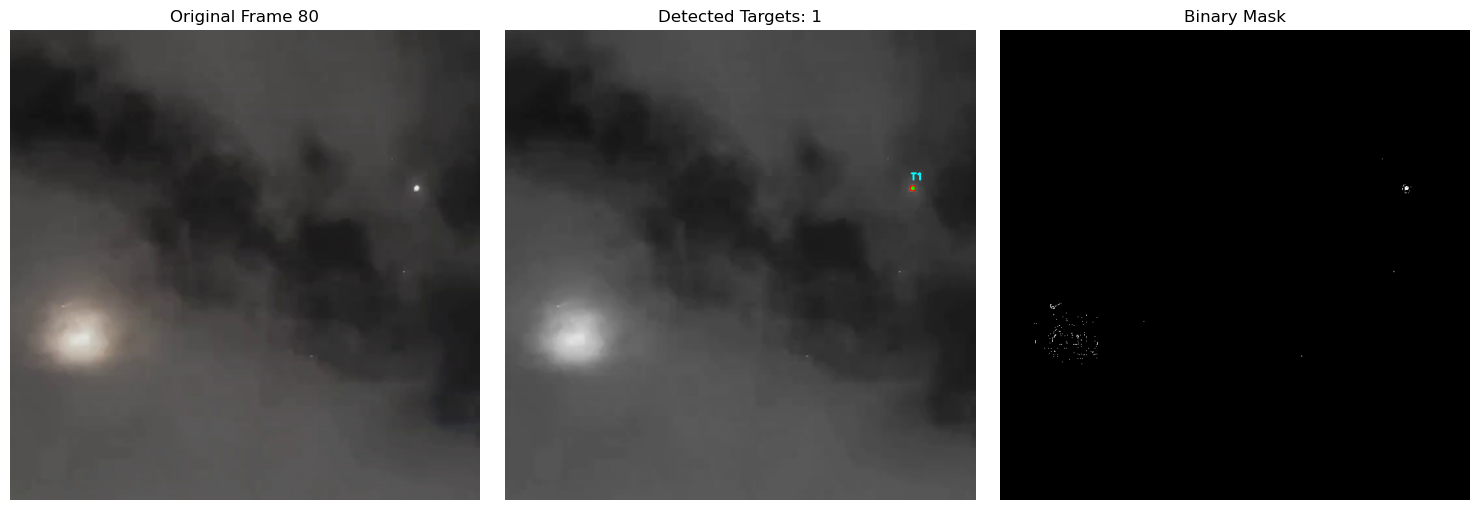

Frame 80: 1 targets at [(623, 242)]
Processed frame 90/281 - Targets detected: 7


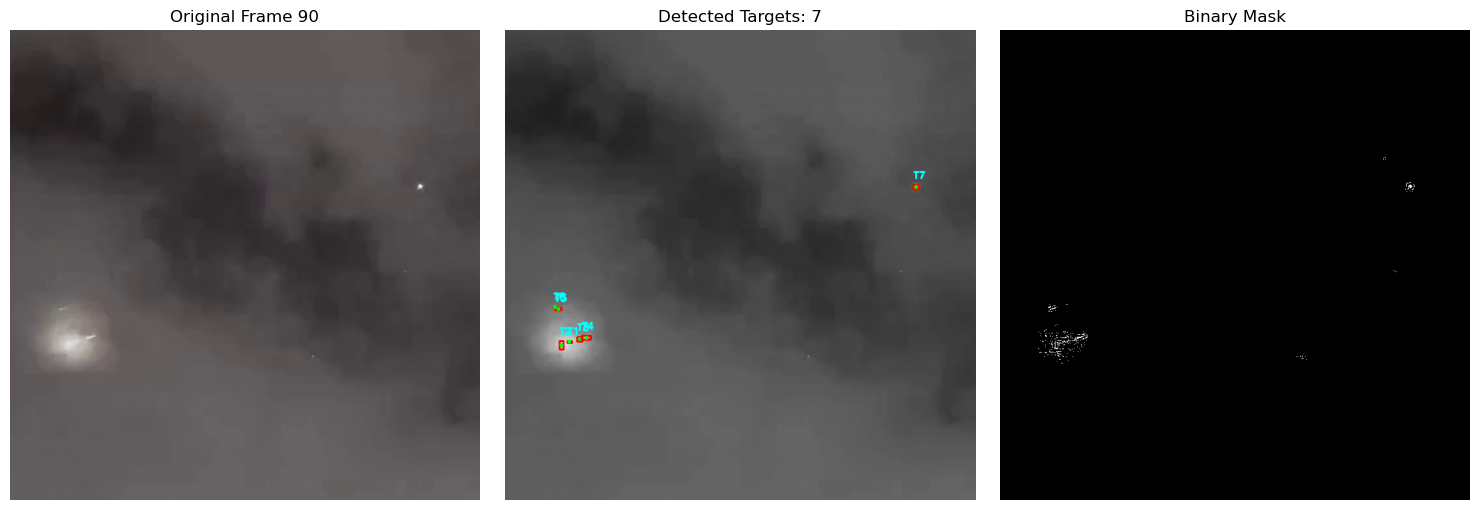

Frame 90: 7 targets at [(98, 477), (86, 482), (114, 473), (124, 471), (81, 427), (76, 424), (628, 240)]


IndexError: index 6 is out of bounds for axis 0 with size 6

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time

class PointTargetDetector:
    def __init__(self):
        self.frame_count = 0
        self.detection_history = []
        
    def compute_point_spread_indicator(self, I0, Im, In):
        # Avoid log(0) issues
        if I0 <= 0 or Im <= 0 or In <= 0:
            return 0
        numerator = np.log(I0) - np.log(Im)
        denominator = np.log(I0) - np.log(In)
        if denominator == 0:
            return 0
        return numerator / denominator

    def point_spread_filter(self, img):
        M, N = img.shape
        padded = np.pad(img, 1, mode='reflect')
        filtered = np.zeros_like(img)

        for i in range(M):
            for j in range(N):
                c = padded[i+1, j+1]
                direct = [padded[i+1, j], padded[i+1, j+2], padded[i, j+1], padded[i+2, j+1]]
                diagonal = [padded[i, j], padded[i, j+2], padded[i+2, j], padded[i+2, j+2]]
                Im = np.mean(direct)
                In = np.mean(diagonal)
                p = self.compute_point_spread_indicator(c, Im, In)
                if 0.35 <= p <= 0.65:
                    filtered[i, j] = c
                else:
                    filtered[i, j] = np.median(padded[i:i+3, j:j+3])
        return filtered

    def point_spread_local_contrast(self, img):
        M, N = img.shape
        padded = np.pad(img, 1, mode='reflect')
        R = np.zeros_like(img)

        for i in range(M):
            for j in range(N):
                I0 = padded[i+1, j+1]
                neighbors = [padded[i+1, j], padded[i+1, j+2], padded[i, j+1], padded[i+2, j+1],
                             padded[i, j], padded[i, j+2], padded[i+2, j], padded[i+2, j+2]]
                direct = [padded[i+1, j], padded[i+1, j+2], padded[i, j+1], padded[i+2, j+1]]
                L = min([I0**2 / (n + 1e-6) for n in neighbors])
                r = (min(direct) / (max(direct) + 1e-6))
                R[i, j] = r * L
        return R

    def high_boost_enhancement(self, PSLCM):
        MF = cv2.GaussianBlur(PSLCM, (9, 9), 1)
        B = np.maximum(PSLCM - MF, 1)
        enhanced = PSLCM * B
        return enhanced

    def normalize_image(self, enhanced_img):
        norm = cv2.normalize(enhanced_img, None, 0, 255, cv2.NORM_MINMAX)
        return norm.astype(np.uint8)

    def threshold_image(self, enhanced_image, method: str = 'static', thresh_val: int = 20):
        if method == 'static':
            thresh = cv2.inRange(enhanced_image, thresh_val, 255)
        elif method == 'adaptive':
            thresh = cv2.adaptiveThreshold(
                enhanced_image, 255,
                cv2.ADAPTIVE_THRESH_MEAN_C,
                cv2.THRESH_BINARY,
                11, 2
            )
        else:
            raise ValueError("Unknown threshold method. Use 'static' or 'adaptive'.")
        return thresh

    def adaptive_segmentation(self, enhanced):
        V = np.sort(enhanced.flatten())[::-1]
        S = np.unique(V)
        len_S = len(S)
        for i in range(min(10, len_S - 2), 1, -1):
            s0, s1, s2 = S[i], S[i + 1], S[i + 2]
            r = (s0 - s1) / (s1 - s2 + 1e-6)
            if r > 0.9:
                T = s0
                break
            elif r < 0.2:
                T = s1
                break
        else:
            T = V[10] if len(V) > 10 else V[-1]
        mask = (enhanced >= T).astype(np.uint8) * 255
        return mask

    def mark_targets_on_original(self, original_img, binary_mask, method='contours'):
        """
        Mark detected targets on the original image with different visualization options
        """
        # Normalize original image to uint8 if needed
        if original_img.dtype != np.uint8:
            original_display = cv2.normalize(original_img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        else:
            original_display = original_img.copy()
        
        # Convert to BGR for colored markings
        if len(original_display.shape) == 2:
            marked_img = cv2.cvtColor(original_display, cv2.COLOR_GRAY2BGR)
        else:
            marked_img = original_display.copy()
        
        target_centers = []
        target_count = 0
        
        if method == 'contours':
            # Find contours of detected targets
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            
            # Draw bounding boxes and center points for each target
            for contour in contours:
                # Filter out very small detections (noise)
                area = cv2.contourArea(contour)
                if area < 3:  # Minimum area threshold
                    continue
                    
                target_count += 1
                
                # Get bounding rectangle
                x, y, w, h = cv2.boundingRect(contour)
                
                # Calculate center
                center_x = x + w // 2
                center_y = y + h // 2
                target_centers.append((center_x, center_y))
                
                # Draw bounding box in red
                cv2.rectangle(marked_img, (x, y), (x + w, y + h), (0, 0, 255), 2)
                
                # Draw center point in green
                cv2.circle(marked_img, (center_x, center_y), 3, (0, 255, 0), -1)
                
                # Add target number label
                cv2.putText(marked_img, f'T{target_count}', (x, y-10), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)
            
        elif method == 'overlay':
            # Create colored overlay
            colored_mask = np.zeros_like(marked_img, dtype=np.uint8)
            colored_mask[binary_mask > 0] = (0, 255, 255)  # Yellow overlay
            
            # Blend with original image
            marked_img = cv2.addWeighted(marked_img, 0.7, colored_mask, 0.3, 0)
        
        return marked_img, target_centers, target_count

    def process_frame(self, frame):
        """Process a single frame and return detection results"""
        # Convert to grayscale if needed
        if len(frame.shape) == 3:
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            gray_frame = frame.copy()
        
        # Convert to float32 for processing
        img = gray_frame.astype(np.float32)
        
        # Apply the point target detection pipeline
        filtered_img = self.point_spread_filter(img)
        PSLCM = self.point_spread_local_contrast(filtered_img)
        enhanced_img = self.high_boost_enhancement(PSLCM)
        enhanced_image = self.normalize_image(enhanced_img)
        binary_mask = self.adaptive_segmentation(enhanced_image)
        
        # Mark targets on original frame
        marked_frame, target_centers, target_count = self.mark_targets_on_original(
            gray_frame, binary_mask, method='contours'
        )
        
        # Store detection info
        detection_info = {
            'frame_number': self.frame_count,
            'target_count': target_count,
            'target_centers': target_centers,
            'timestamp': time.time()
        }
        
        self.detection_history.append(detection_info)
        self.frame_count += 1
        
        return marked_frame, binary_mask, detection_info

def process_video_file(video_path, output_path=None, display_results=True, save_frames=False):
    """
    Process a video file for point target detection
    """
    detector = PointTargetDetector()
    
    # Open video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print(f"Error: Cannot open video file {video_path}")
        return None
    
    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Video properties: {width}x{height}, {fps} FPS, {total_frames} frames")
    
    # Initialize video writer if output path is provided
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    frame_results = []
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Process frame
            marked_frame, binary_mask, detection_info = detector.process_frame(frame)
            frame_results.append(detection_info)
            
            # Display progress
            if detector.frame_count % 30 == 0:  # Every 30 frames
                print(f"Processed frame {detector.frame_count}/{total_frames} - "
                      f"Targets detected: {detection_info['target_count']}")
            
            # Save processed frame
            if output_path:
                out.write(marked_frame)
            
            # Display results in Jupyter Notebook (every 10th frame to avoid flooding)
            if display_results and detector.frame_count % 10 == 0:
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title(f'Original Frame {detector.frame_count}')
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                plt.imshow(cv2.cvtColor(marked_frame, cv2.COLOR_BGR2RGB))
                plt.title(f'Detected Targets: {detection_info["target_count"]}')
                plt.axis('off')
                
                plt.subplot(1, 3, 3)
                plt.imshow(binary_mask, cmap='gray')
                plt.title('Binary Mask')
                plt.axis('off')
                
                plt.tight_layout()
                plt.show()
                
                # Print detection summary
                if detection_info['target_centers']:
                    print(f"Frame {detector.frame_count}: {detection_info['target_count']} targets at {detection_info['target_centers']}")
            
            # Save individual frames if requested
            if save_frames and detector.frame_count % 30 == 0:
                cv2.imwrite(f'frame_{detector.frame_count:04d}_marked.jpg', marked_frame)
                cv2.imwrite(f'frame_{detector.frame_count:04d}_mask.jpg', binary_mask)
    
    except KeyboardInterrupt:
        print("Processing interrupted by user")
    
    finally:
        cap.release()
        if output_path:
            out.release()
    
    print(f"\nProcessing complete! Processed {detector.frame_count} frames")
    print(f"Detection history saved with {len(detector.detection_history)} entries")
    
    return detector, frame_results

def process_webcam_live(duration=30, display_interval=1):
    """
    Process live webcam feed for point target detection
    """
    detector = PointTargetDetector()
    
    # Open webcam
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Error: Cannot open webcam")
        return None
    
    start_time = time.time()
    last_display = 0
    
    print(f"Starting live webcam processing for {duration} seconds...")
    print("Press 'q' to quit early")
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Failed to grab frame")
                break
            
            # Check if duration exceeded
            current_time = time.time()
            if current_time - start_time > duration:
                break
            
            # Process frame
            marked_frame, binary_mask, detection_info = detector.process_frame(frame)
            
            # Display results at specified interval
            if current_time - last_display > display_interval:
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title(f'Live Feed - Frame {detector.frame_count}')
                plt.axis('off')
                
                plt.subplot(1, 3, 2)
                plt.imshow(cv2.cvtColor(marked_frame, cv2.COLOR_BGR2RGB))
                plt.title(f'Targets: {detection_info["target_count"]}')
                plt.axis('off')
                
                plt.subplot(1, 3, 3)
                plt.imshow(binary_mask, cmap='gray')
                plt.title('Detection Mask')
                plt.axis('off')
                
                plt.tight_layout()
                plt.show()
                
                if detection_info['target_centers']:
                    print(f"Targets detected: {detection_info['target_centers']}")
                
                last_display = current_time
    
    except KeyboardInterrupt:
        print("Live processing interrupted by user")
    
    finally:
        cap.release()
    
    print(f"\nLive processing complete! Processed {detector.frame_count} frames")
    return detector

def analyze_detection_results(detector):
    """
    Analyze and visualize detection results
    """
    if not detector.detection_history:
        print("No detection history available")
        return
    
    # Extract data for analysis
    frame_numbers = [d['frame_number'] for d in detector.detection_history]
    target_counts = [d['target_count'] for d in detector.detection_history]
    
    # Plot detection statistics
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(frame_numbers, target_counts)
    plt.title('Targets Detected Over Time')
    plt.xlabel('Frame Number')
    plt.ylabel('Number of Targets')
    plt.grid(True)
    
    plt.subplot(2, 2, 2)
    plt.hist(target_counts, bins=max(target_counts)+1, alpha=0.7)
    plt.title('Distribution of Target Counts')
    plt.xlabel('Number of Targets')
    plt.ylabel('Frequency')
    plt.grid(True)
    
    plt.subplot(2, 2, 3)
    total_detections = sum(target_counts)
    avg_detections = np.mean(target_counts)
    max_detections = max(target_counts)
    
    stats_text = f"""
    Total Frames: {len(frame_numbers)}
    Total Detections: {total_detections}
    Average per Frame: {avg_detections:.2f}
    Maximum in Frame: {max_detections}
    Frames with Detections: {sum(1 for c in target_counts if c > 0)}
    """
    
    plt.text(0.1, 0.5, stats_text, fontsize=12, verticalalignment='center')
    plt.title('Detection Statistics')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    detection_rate = [1 if c > 0 else 0 for c in target_counts]
    window_size = min(50, len(detection_rate))
    if window_size > 1:
        smoothed_rate = np.convolve(detection_rate, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(detection_rate)), smoothed_rate)
        plt.title(f'Detection Rate (Moving Average, Window={window_size})')
        plt.xlabel('Frame Number')
        plt.ylabel('Detection Rate')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Main execution function
def main():
    print("Point Target Detection for Video")
    print("=" * 40)
    
    # Example usage - replace with your video file path
    video_file = "Downloads/test video.mp4"  # Update this path
    
    # Check if video file exists
    if os.path.exists(video_file):
        print(f"Processing video file: {video_file}")
        detector, results = process_video_file(
            video_file, 
            output_path="Videos/output video.mp4",
            display_results=True,
            save_frames=False
        )
        
        if detector:
            analyze_detection_results(detector)
    else:
        print(f"Video file not found: {video_file}")
        print("Please update the video_file path or use webcam processing")
        
        # Alternative: Process webcam (uncomment to use)
        # print("Starting webcam processing...")
        # detector = process_webcam_live(duration=30, display_interval=2)
        # if detector:
        #     analyze_detection_results(detector)

if __name__ == "__main__":
    main()
